<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Preprocessing-Images" data-toc-modified-id="Preprocessing-Images-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing Images</a></span></li><li><span><a href="#GANs:-Discrimator-and-Generator" data-toc-modified-id="GANs:-Discrimator-and-Generator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>GANs: Discrimator and Generator</a></span></li><li><span><a href="#Training-NNs" data-toc-modified-id="Training-NNs-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training NNs</a></span></li><li><span><a href="#Testing-NNs" data-toc-modified-id="Testing-NNs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Testing NNs</a></span></li></ul></div>

# GANs for Anime Faces

The main idea of this notebook is to use GANs in order to generate fake anime faces. I would use the tutorial [GANs from Scratch 1: A deep introduction. With code in PyTorch and TensorFlow](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f).

By the end of this little project, I hope to have some realistic anime faces.

In [1]:
#Loading the required libraries
import torch
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import glob
from PIL import Image
# from utils import Logger

## Functions

This section contains the functions that will be used in the Notebook.

In [2]:
#Define the required functions
def images_to_vectors(images, value):
    return images.view(images.size(0), value)

def vectors_to_images(vectors, rows, cols):
    return vectors.view(vectors.size(0), 1, rows, cols)

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [3]:
#Execute the file Logger.py
exec(open('../Scripts/Logger.py').read())

## Preprocessing Images

This section contains the reading and preprocessing of the anime faces obtained in [Anime Faces](https://www.kaggle.com/soumikrakshit/anime-faces/data) and the ones thanks to [Brian Chao](https://github.com/Mckinsey666) and his repostory [Anime-Face-Dataset](https://github.com/Mckinsey666/Anime-Face-Dataset). 

In [5]:
#Create transformers image to tensor and tensor to image 
trans_0 = transforms.ToPILImage()
trans_1 = transforms.ToTensor()
trans_2 = transforms.Normalize(mean=(0.5,), std=(0.5,))

In [6]:
#Read the images and createds a list with the images in tensor format
images_path = glob.glob("../Images/*png")
images_data = []
no_charged = 0
for idx, image in enumerate(images_path):
    try:
        img = Image.open(image)
        img_tensor = trans_2(trans_1(transforms.functional.to_grayscale(img)))
        images_data.append(img_tensor)
    except:
        no_charged += 1
        pass
    if idx % 4000 == 0 and idx > 0:
        print('IMAGE NUMBER', idx)
#Print the number of images non charged
print('NON CHARGED', no_charged, 'IMAGES')

IMAGE NUMBER 4000
IMAGE NUMBER 8000
IMAGE NUMBER 12000
IMAGE NUMBER 16000
IMAGE NUMBER 20000
NON CHARGED 0 IMAGES


In [7]:
#Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(images_data, batch_size=100, shuffle=True)
num_batches = len(data_loader)
print(num_batches, 'BACHTES')

216 BACHTES


In [8]:
pixel_rows = images_data[0].shape[1]
pixel_cols = images_data[0].shape[2]
print(pixel_rows, pixel_cols)

64 64


## GANs: Discrimator and Generator

In this section we define the architecture of the two neural networks: the discriminator and the generator using the code in [GANs from Scratch 1: A deep introduction. With code in PyTorch and TensorFlow](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f).

In [9]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = pixel_rows*pixel_cols
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [10]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out =  pixel_rows*pixel_cols
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

## Training NNs

This section trains the neural networks.

In [11]:
#Define the optimizers and lossfor the NNs
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()

In [12]:
#Trains the discriminator with real and fake data 
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    #Reset gradients
    optimizer.zero_grad()
    
    #1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    #1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    #1.3 Update weights with gradients
    optimizer.step()
    
    #Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [13]:
#Trains the generator of fake data
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    
    #Reset gradients
    optimizer.zero_grad()
    
    #Sample noise and generate fake data
    prediction = discriminator(fake_data)
    
    #Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    
    #Update weights with gradients
    optimizer.step()
    
    #Return error
    return error

In [14]:
#Noise every single sixteen steps to see what happens
num_test_samples = 16
test_noise = noise(num_test_samples)

## Testing NNs

This sections generates the fake anime faces and allows us to see the output.

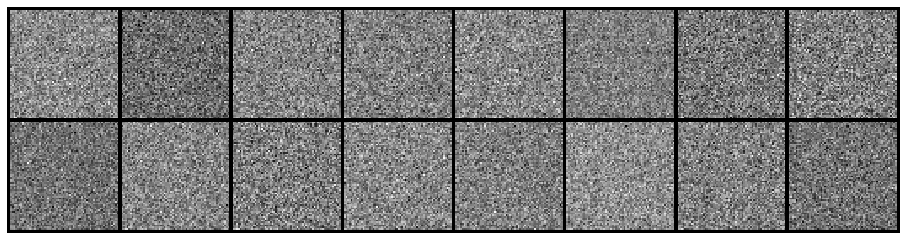

Epoch: [0/200], Batch Num: [0/216]
Discriminator Loss: 1.3966, Generator Loss: 0.7161
D(x): 0.4843, D(G(z)): 0.4890


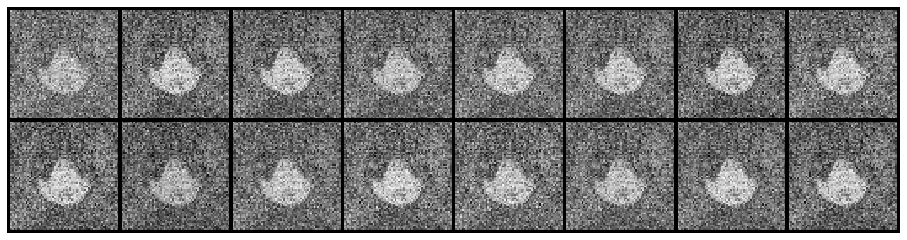

Epoch: [0/200], Batch Num: [100/216]
Discriminator Loss: 0.1166, Generator Loss: 3.0448
D(x): 0.9688, D(G(z)): 0.0779


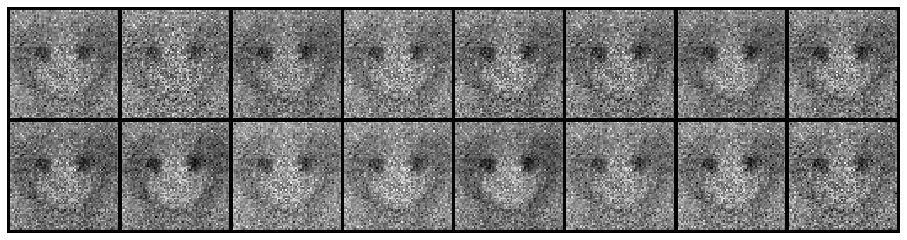

Epoch: [0/200], Batch Num: [200/216]
Discriminator Loss: 0.1946, Generator Loss: 2.5847
D(x): 0.9773, D(G(z)): 0.1552


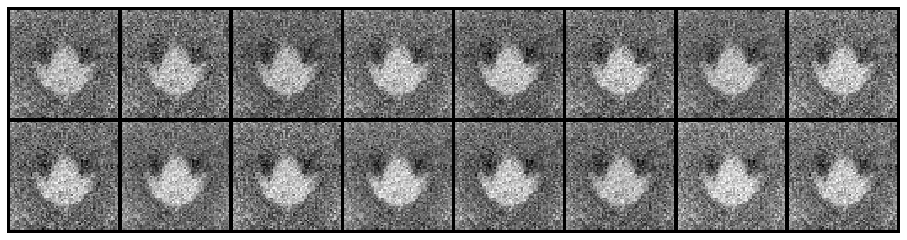

Epoch: [1/200], Batch Num: [0/216]
Discriminator Loss: 0.7584, Generator Loss: 1.0395
D(x): 0.9660, D(G(z)): 0.5068


In [ ]:
#Create logger instance
logger = Logger(model_name='VGAN', data_name='ANIME-FACES')
#Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, real_batch in enumerate(data_loader):
        N = real_batch.size(0)
        #1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch, value=pixel_rows*pixel_cols))
        #Generate fake data and detach 
        #(so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        #Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        #2. Train Generator
        #Generate fake data
        fake_data = generator(noise(N))
        #Train G
        g_error = train_generator(g_optimizer, fake_data)
        #Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        #Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise), rows=pixel_rows, cols=pixel_cols)
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            #Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )